Wikidata link: [http://www.wikidata.org/entity/Q119423701](http://www.wikidata.org/entity/Q119423701)

Title: Topf

Year: 1901-01-01T00:00:00Z

Discoverer: Johann Heinrich Ludwig Petersen



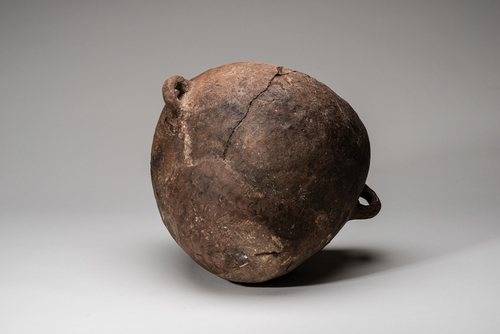




Wikidata link: [http://www.wikidata.org/entity/Q119423703](http://www.wikidata.org/entity/Q119423703)

Title: Deckel

Year: 1901-01-01T00:00:00Z

Discoverer: Johann Heinrich Ludwig Petersen



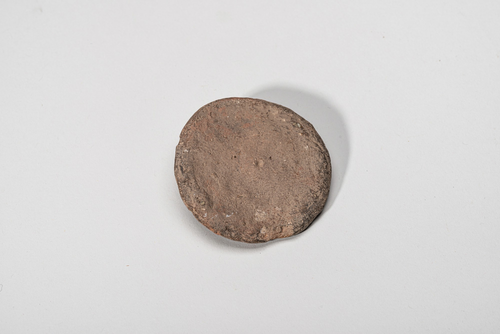




Wikidata link: [http://www.wikidata.org/entity/Q119423703](http://www.wikidata.org/entity/Q119423703)

Title: Deckel

Year: 1901-01-01T00:00:00Z

Discoverer: Johann Heinrich Ludwig Petersen



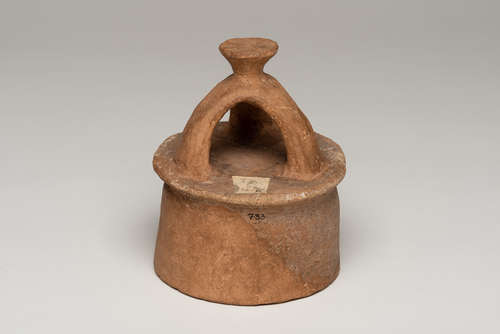




Wikidata link: [http://www.wikidata.org/entity/Q119423705](http://www.wikidata.org/entity/Q119423705)

Title: Kännchen

Year: 1901-01-01T00:00:00Z

Discoverer: Johann Heinrich Ludwig Petersen



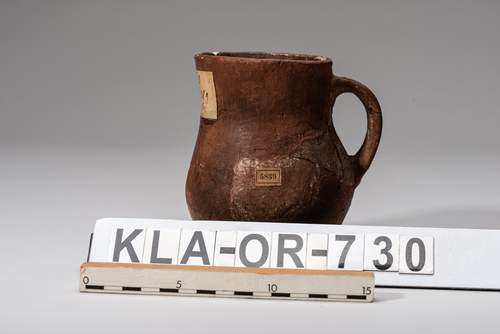




Wikidata link: [http://www.wikidata.org/entity/Q119423706](http://www.wikidata.org/entity/Q119423706)

Title: Schale

Year: 1901-01-01T00:00:00Z

Discoverer: Johann Heinrich Ludwig Petersen



KeyError: 'image'

In [1]:
from SPARQLWrapper import SPARQLWrapper, JSON
from PIL import Image
import requests

# VARIABLES

sparql_endpoint_url = 'https://query.wikidata.org/bigdata/namespace/wdq/sparql'
wikibase_url = 'https://www.wikidata.org'
api_url = '/w/api.php'

# Wikidata requires a user agent header to prevent spam requests
user_agent = 'Ex_Books_conference_bot/0.0 (https://github.com/SimonXIX/Experimental_Books_workshop; ad7588@coventry.ac.uk)'

# SPARQL query
# see in Wikidata's Query Service GUI at:
# https://query.wikidata.org/#%23defaultView%3AImageGrid%0ASELECT%20%3Fitem%20%3FitemLabel%20%3Finceptionyear%20%3Fcreator%20%3FcreatorLabel%20%3Fcopyright%20%3FcopyrightLabel%20%3Fimage%0AWHERE%0A%7B%0A%20%20%23%20find%20items%20which%3A%0A%20%20%23%20are%20instances%20of%20%28wdt%3AP31%29%20paintings%20%28wd%3AQ3305213%29%0A%20%20%23%20have%20the%20property%20%28wdt%3AP195%29%20of%20being%20in%20collection%20wd%3AQ812285%20%28Bavarian%20State%20Painting%20Collections%20https%3A%2F%2Fwww.wikidata.org%2Fwiki%2FWikidata%3AWikiProject_sum_of_all_paintings%2FCollection%2FBavarian_State_Painting_Collections%29%0A%20%20%3Fitem%20wdt%3AP31%20wd%3AQ3305213%20.%0A%20%20%3Fitem%20wdt%3AP195%20wd%3AQ812285%20.%0A%20%20%23%20get%20the%20item%27s%20creator%20property%20%28wdt%3AP170%29%0A%20%20%3Fitem%20wdt%3AP170%20%3Fcreator%20.%0A%20%20%23%20get%20the%20item%27s%20image%20property%20%28wdt%3AP18%29%0A%20%20%3Fitem%20wdt%3AP18%20%3Fimage%20.%0A%20%20%23%20get%20the%20item%27s%20copyright%20status%20%28wdt%3AP6216%29%0A%20%20%3Fitem%20wdt%3AP6216%20%3Fcopyright%20.%20%0A%20%20%7B%0A%20%20%20%20%3Fitem%20wdt%3AP571%20%3Finception.%0A%20%20%20%20BIND%28YEAR%28%3Finception%29%20AS%20%3Finceptionyear%29%0A%20%20%7D%0A%0A%20%20%23%20filter%20out%20all%20paintings%20not%20created%20between%20the%20years%201600%20and%201700%0A%20%20FILTER%28%281600%20%20%3C%3D%20%3Finceptionyear%29%20%26%26%20%28%3Finceptionyear%20%3C%201700%20%29%29%0A%20%20SERVICE%20wikibase%3Alabel%20%7B%20bd%3AserviceParam%20wikibase%3Alanguage%20%22%5BAUTO_LANGUAGE%5D%2Cen%22.%20%7D%20%7D%0A%23%20limit%20to%20nine%20results%0ALIMIT%209
query = """
#defaultView:ImageGrid
SELECT ?instance_of ?instance_ofLabel ?inception ?collection ?collectionLabel ?discoverer_or_inventor ?discoverer_or_inventorLabel ?location_of_discovery ?location_of_discoveryLabel ?image WHERE {
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
  ?instance_of wdt:P31 wd:Q18593264. 
  ?instance_of wdt:P195 wd:Q93531035.
  ?instance_of wdt:P61 wd:Q97105543.
  OPTIONAL { ?instance_of wdt:P571 ?inception. }
  OPTIONAL { ?instance_of wdt:P195 ?collection. }
  OPTIONAL { ?instance_of wdt:P61 ?discoverer_or_inventor. }
  OPTIONAL { ?instance_of wdt:P189 ?location_of_discovery. }
  OPTIONAL { ?instance_of wdt:P18 ?image. }
}
LIMIT 100
"""

# SUBROUTINES

def get_delay(date):
    try:
        date = datetime.datetime.strptime(date, '%a, %d %b %Y %H:%M:%S GMT')
        timeout = int((date - datetime.datetime.now()).total_seconds())
    except ValueError:
        timeout = int(date)
    return timeout

def get_image(url, headers):
    r = requests.get(url, headers=headers, stream=True)
    if r.status_code == 200:
        im = Image.open(r.raw)
        return im
    if r.status_code == 500:
        return None
    if r.status_code == 403:
        return None
    if r.status_code == 429:
        timeout = get_delay(r.headers['retry-after'])
        print('Timeout {} m {} s'.format(timeout // 60, timeout % 60))
        time.sleep(timeout)
        get_image(url, headers)

# MAIN PROGRAM

# create SPARQL query
sparql = SPARQLWrapper(sparql_endpoint_url, agent=user_agent)

# retrieve results and convert to JSON format
sparql.setQuery(query)
sparql.setReturnFormat(JSON)
result = sparql.query().convert()

# for each result, print various data fields
for item in result['results']['bindings']:
    print('Wikidata link: ' + '[' + item['instance_of']['value'] + ']' + '(' + item['instance_of']['value'] + ')' + '\n')
    print('Title: ' + item['instance_ofLabel']['value'] + '\n')
    print('Year: ' + item['inception']['value'] + '\n')
    print('Discoverer: ' + item['discoverer_or_inventorLabel']['value'] + '\n')

    
    

    # get image from image URL and display resized version
    image_url=item['image']['value']
    headers = {'User-Agent': 'Ex_Books_conference_bot/0.0 (https://github.com/SimonXIX/Experimental_Books_workshop; ad7588@coventry.ac.uk)'}
    im = get_image(image_url, headers)
    im.thumbnail((500, 500), Image.Resampling.LANCZOS)
    display(im)
    print('\n\n')